In [1]:
from mdagent import MDAgent
import os 
import mdtraj as md

In [2]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.append(parent_dir)
from robustness_prompts import get_prompt

prompt_8_descriptive = get_prompt("descriptive", 8)
prompt_8_natural = get_prompt("natural", 8)

prompt_8_descriptive, prompt_8_natural

('Complete all of the following tasks: 1. Download the PDB file 1LYZ. 2. Report the secondary structure assignments of the downloaded PDB structure. 3. Find any known binding or active sites. 4. Simulate for 1ps at 300 K. 5. Compute the RMSD. 6. Compute the radius of gyration over time. 7. Compute the SASA (solvent accessible surface area). 8. Simulate for 1ps at 400K. You do not need to do any analysis of the 400K simulation.',
 'Simulate 1LYZ for 1ps at 300 K and for 1ps at 400K. Report the secondary structure assignments of the downloaded PDB structure and any known binding or active sites. Compute the RMSD, SASA, and radius of gyration of the 300K simulation.')

In [3]:
llm_model = "claude-3-5-sonnet-20240620"
tools = "all"

In [4]:
agent_1 = MDAgent(agent_type="Structured", model=llm_model, top_k_tools=tools, use_memory=False)
agent_1.run(prompt_8_descriptive)

Thought: To complete all these tasks, I'll need to use several tools in sequence. Let's start with downloading the PDB file.

Action:
```
{
    "action": "PDBFileDownloader",
    "action_input": "1LYZ"
}
```PDB file found with this ID: 1LYZ
Thought: Great, we've successfully downloaded the PDB file for 1LYZ. Now, let's move on to the next task, which is to report the secondary structure assignments of the downloaded PDB structure.

Action:
```
{
    "action": "ComputeDSSP",
    "action_input": {
        "traj_file": "1LYZ_183059",
        "top_file": "1LYZ_183059",
        "target_frames": "first"
    }
}
```Thought: We've successfully obtained the secondary structure assignments for 1LYZ. Now, let's move on to finding any known binding or active sites for this protein. We'll use the GetAllKnownSites tool, but first, we need to get the UniProt ID for 1LYZ.

Action:
```
{
    "action": "MapProteinRepresentation",
    "action_input": {
        "query": "1LYZ",
        "src_db": "PDB",
  

({'input': '\n    You are an expert molecular dynamics scientist, and\n    your task is to respond to the question or\n    solve the problem to the best of your ability using\n    the provided tools.\n\n    You can only respond with a single complete\n    \'Thought, Action, Action Input\' format\n    OR a single \'Final Answer\' format.\n\n    Complete format:\n    Thought: (reflect on your progress and decide what to do next)\n    Action:\n    ```\n    {\n        "action": (the action name, it should be the name of a tool),\n        "action_input": (the input string for the action)\n    }\n    \'\'\'\n\n    OR\n\n    Final Answer: (the final response to the original input\n    question, once all steps are complete)\n\n    You are required to use the tools provided,\n    using the most specific tool\n    available for each action.\n    Your final answer should contain all information\n    necessary to answer the question and its subquestions.\n    Before you finish, reflect on your pro

<Figure size 640x480 with 0 Axes>

In [5]:
registry_1 = agent_1.path_registry
print(registry_1.list_path_names_and_descriptions().replace(",", "\n"))

Files found in registry: 1LYZ_183059: PDB file downloaded from RSCB
 PDBFile ID: 1LYZ_183059
 rec0_183102: dssp values for trajectory with id: 1LYZ_183059
 rec0_183130: dssp values for trajectory with id: 1LYZ_183059
 1LYZ_183248: Cleaned File:  Removed Heterogens
 and Water Removed.  Replaced Nonstandard Residues. Added Hydrogens at pH 7.0. Missing Atoms Added and replaces nonstandard residues. 
 top_sim0_183313: Initial positions for simulation sim0_183313
 sim0_183313: Basic Simulation of Protein 1LYZ_183248
 rec0_183314: Simulation trajectory for protein 1LYZ_183248 and simulation sim0_183313
 rec1_183314: Simulation state log for protein 1LYZ_183248 and simulation sim0_183313
 rec2_183314: Simulation pdb frames for protein 1LYZ_183248 and simulation sim0_183313
 rmsd_Lysozyme C: RMSD for Lysozyme C
 fig0_183413: RMSD plot for Lysozyme C
 rgy_rec0_183314: Radii of gyration per frame for rec0_183314
 fig0_183438: Plot of radii of gyration over time for rec0_183314
 sasa_Lysozyme C: 

In [6]:
# make sure pdb was downloaded
assert os.path.exists(registry_1.get_mapped_path("1LYZ_183059"))

In [7]:
# make sure dssp was computed correctly
from mdagent.tools.base_tools import ComputeDSSP

dssp = ComputeDSSP(registry_1)
dssp._run(traj_file= "1LYZ_183059", target_frames="first")

"{'residues in helix': 50, 'residues in strand': 14, 'residues in coil': 65, 'residues not assigned, not a protein residue': 101}"

In [8]:
# make sure the sites were found
from mdagent.tools.base_tools import GetAllKnownSites

get_all_known_sites = GetAllKnownSites()
get_all_known_sites._run(query="1LYZ", primary_accession="P00698")

"Active Sites: [{'start': 53, 'start_modifier': 'EXACT', 'end': 53, 'end_modifier': 'EXACT', 'description': '', 'evidences': []}, {'start': 70, 'start_modifier': 'EXACT', 'end': 70, 'end_modifier': 'EXACT', 'description': '', 'evidences': []}]\nBinding Sites: [{'start': 119, 'start_modifier': 'EXACT', 'end': 119, 'end_modifier': 'EXACT', 'description': '', 'evidences': []}]\nNo other relevant sites."

In [4]:
# make sure trajectory and topology exist (sim1)
traj_path_1_1 = registry_1.get_mapped_path("rec0_183314")
top_path_1_1 = registry_1.get_mapped_path("top_sim0_183313")

assert os.path.exists(traj_path_1_1)
assert os.path.exists(top_path_1_1)

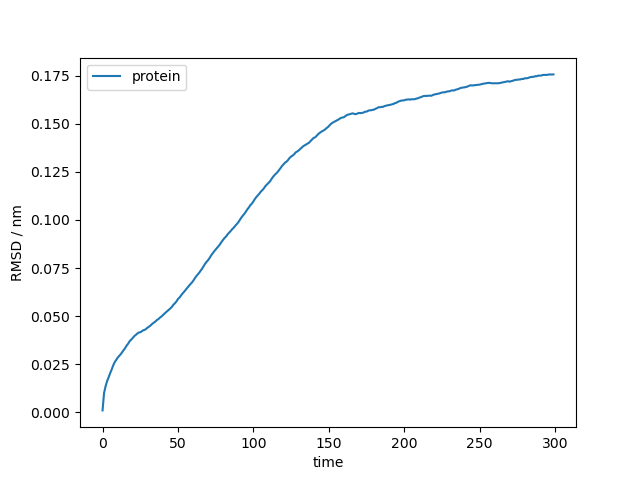

In [5]:
# make sure rmsd plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_183413'))

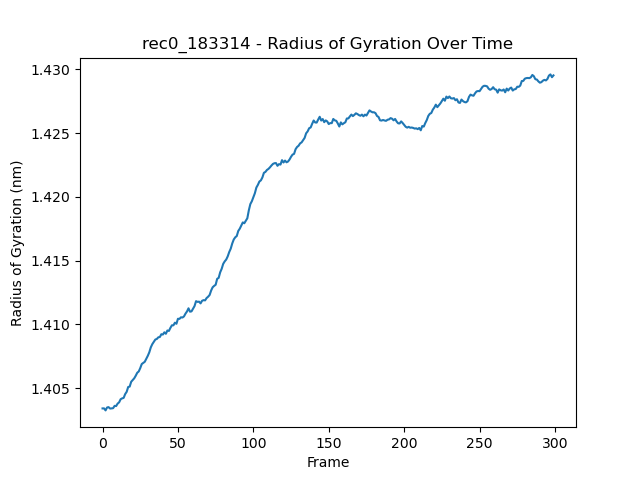

In [14]:
# make sure rgy plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_183438'))

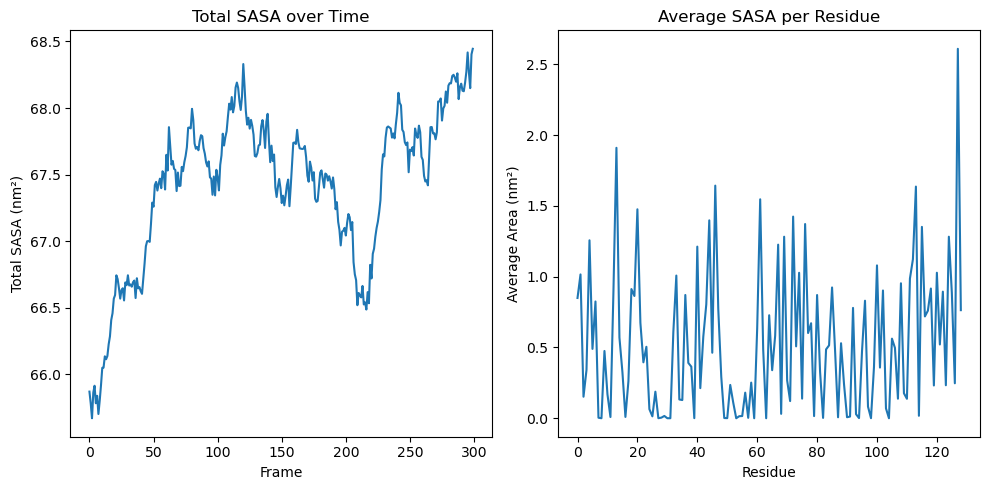

In [13]:
# make sure sasa plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_183540'))

In [12]:
# make sure trajectory and topology exist (sim2)
traj_path_1_2 = registry_1.get_mapped_path("rec0_183607")
top_path_1_2 = registry_1.get_mapped_path("top_sim0_183607")

assert os.path.exists(traj_path_1_2)
assert os.path.exists(top_path_1_2)

In [15]:
agent_2 = MDAgent(agent_type="Structured", model=llm_model, top_k_tools=tools, use_memory=False)
agent_2.run(prompt_8_natural)

Thought: To address this question, we need to break it down into several steps. Let's start by downloading the PDB file for 1LYZ, then simulate it at different temperatures, analyze its structure, and compute various properties. We'll begin by downloading the PDB file.

Action:
```
{
    "action": "PDBFileDownloader",
    "action_input": "1LYZ"
}
```PDB file found with this ID: 1LYZ
Thought: Great, we have successfully downloaded the PDB file for 1LYZ. Now, let's analyze the secondary structure assignments, binding sites, and active sites of this protein before we proceed with the simulations.

Action:
```
{
    "action": "ComputeDSSP",
    "action_input": {
        "traj_file": "1LYZ_184526",
        "top_file": "1LYZ_184526",
        "target_frames": "first"
    }
}
```Thought: We've obtained the secondary structure information for 1LYZ. Now, let's get information about its binding sites and active sites. We'll use the UniProt database for this information, but first, we need to map 

({'input': '\n    You are an expert molecular dynamics scientist, and\n    your task is to respond to the question or\n    solve the problem to the best of your ability using\n    the provided tools.\n\n    You can only respond with a single complete\n    \'Thought, Action, Action Input\' format\n    OR a single \'Final Answer\' format.\n\n    Complete format:\n    Thought: (reflect on your progress and decide what to do next)\n    Action:\n    ```\n    {\n        "action": (the action name, it should be the name of a tool),\n        "action_input": (the input string for the action)\n    }\n    \'\'\'\n\n    OR\n\n    Final Answer: (the final response to the original input\n    question, once all steps are complete)\n\n    You are required to use the tools provided,\n    using the most specific tool\n    available for each action.\n    Your final answer should contain all information\n    necessary to answer the question and its subquestions.\n    Before you finish, reflect on your pro

<Figure size 640x480 with 0 Axes>

In [16]:
registry_2 = agent_2.path_registry
print(registry_2.list_path_names_and_descriptions().replace(",", "\n"))

Files found in registry: 1LYZ_184526: PDB file downloaded from RSCB
 PDBFile ID: 1LYZ_184526
 rec0_184530: dssp values for trajectory with id: 1LYZ_184526
 1LYZ_184601: Cleaned File:  Removed Heterogens
 and Water Removed.  Replaced Nonstandard Residues. Added Hydrogens at pH 7.0. Missing Atoms Added and replaces nonstandard residues. 
 top_sim0_184606: Initial positions for simulation sim0_184606
 sim0_184606: Basic Simulation of Protein 1LYZ_184601
 rec0_184610: Simulation trajectory for protein 1LYZ_184601 and simulation sim0_184606
 rec1_184610: Simulation state log for protein 1LYZ_184601 and simulation sim0_184606
 rec2_184610: Simulation pdb frames for protein 1LYZ_184601 and simulation sim0_184606
 top_sim0_185211: Initial positions for simulation sim0_185211
 sim0_185211: Basic Simulation of Protein 1LYZ_184601
 rec0_185216: Simulation trajectory for protein 1LYZ_184601 and simulation sim0_185211
 rec1_185216: Simulation state log for protein 1LYZ_184601 and simulation sim0_18

In [20]:
# make sure pdb was downloaded
assert os.path.exists(registry_2.get_mapped_path("1LYZ_184526"))

In [21]:
# make sure dssp was computed correctly
from mdagent.tools.base_tools import ComputeDSSP

dssp = ComputeDSSP(registry_2)
dssp._run(traj_file= "1LYZ_184526", target_frames="first")

"{'residues in helix': 50, 'residues in strand': 14, 'residues in coil': 65, 'residues not assigned, not a protein residue': 101}"

In [24]:
# make sure the sites were found
from mdagent.tools.base_tools import GetAllKnownSites

get_all_known_sites = GetAllKnownSites()
get_all_known_sites._run(query="1LYZ", primary_accession="P61626")

The primary accession number provided does not match any entry in the data, using the first entry instead.
The primary accession number provided does not match any entry in the data, using the first entry instead.
The primary accession number provided does not match any entry in the data, using the first entry instead.


"Active Sites: [{'start': 53, 'start_modifier': 'EXACT', 'end': 53, 'end_modifier': 'EXACT', 'description': '', 'evidences': [{'evidenceCode': 'ECO:0000255', 'source': 'PROSITE-ProRule', 'id': 'PRU00680'}]}, {'start': 71, 'start_modifier': 'EXACT', 'end': 71, 'end_modifier': 'EXACT', 'description': '', 'evidences': [{'evidenceCode': 'ECO:0000255', 'source': 'PROSITE-ProRule', 'id': 'PRU00680'}]}]\nNo known binding sites.\nNo other relevant sites."

In [27]:
# make sure trajectory and topology exist (sim1)
traj_path_2_1 = registry_2.get_mapped_path("rec0_184610")
top_path_2_1 = registry_2.get_mapped_path("top_sim0_184606")

assert os.path.exists(traj_path_2_1)
assert os.path.exists(top_path_2_1)

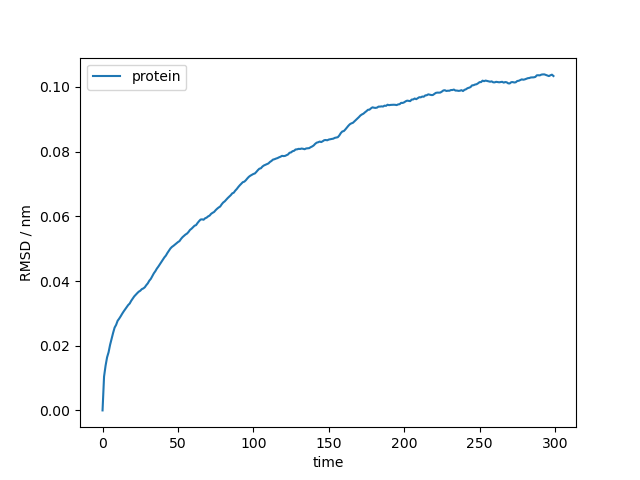

In [28]:
# make sure rmsd plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_185747'))

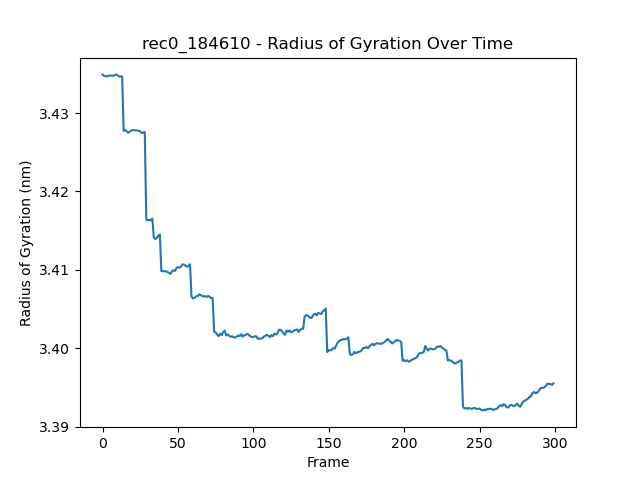

In [29]:
# make sure rgy plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_190720'))

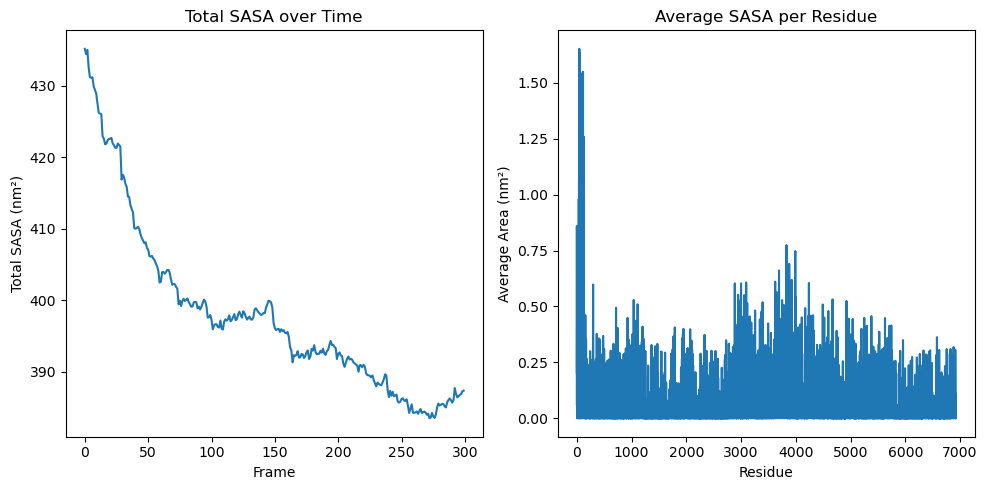

In [30]:
# make sure sasa plot was generated (sim2)
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_190716'))

In [31]:
# make sure trajectory and topology exist (sim1)
traj_path_2_2 = registry_2.get_mapped_path("rec0_185216")
top_path_2_2 = registry_2.get_mapped_path("top_sim0_185211")

assert os.path.exists(traj_path_2_2)
assert os.path.exists(top_path_2_2)